In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft
from scipy.io import loadmat
from scipy.signal import spectrogram

In [2]:
eeg_mat = loadmat('OngoingEEG_data.mat')
eeg_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'samplingRate'])

In [3]:
eeg = eeg_mat['EEGData'].ravel()

fs = eeg_mat['samplingRate'].ravel()[0]
N = eeg.shape[0]
t = np.linspace(0, N / fs, N, endpoint=False)

In [4]:
eeg_mat['EEGPoints']

array([[334848]], dtype=uint32)

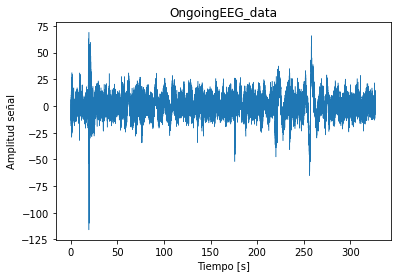

In [5]:
fig, ax = plt.subplots()
ax.plot(t, eeg, linewidth=.5)
ax.set_title('OngoingEEG_data')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud señal')
fig.savefig('fig/q1_ongoing_signal.png')

9.250764525993883


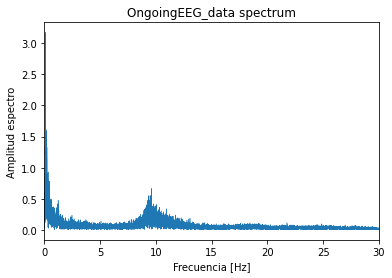

In [8]:
xf = fft(eeg)[:N // 2]
ff = fftfreq(N, 1 / fs)[:N // 2]

fig, ax = plt.subplots()
ax.plot(ff, 2 * np.abs(xf) / N, linewidth=.5)
ax.set_xlim([0, 30])
ax.set_title('OngoingEEG_data spectrum')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Amplitud espectro')
fig.savefig('fig/q1_ongoing_fft.png')

filt = ff > 2.5
print(ff[filt][np.argmax(xf[filt])])

163.50
40.87
20.44


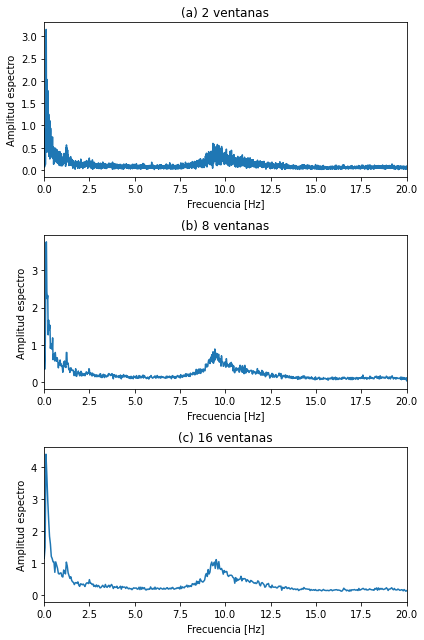

In [92]:
def win_fft(win_size):
    win_size = int(win_size)

    fft_arr = []
    ff = fftfreq(win_size, 1 / fs)[:win_size // 2]
    k = 0

    while k < t.shape[0]:
        xf = fft(eeg[k : k + win_size])[:win_size // 2]
        fft_arr.append(xf)

        k += win_size

    mxf = 2 / win_size * np.mean(np.abs(np.array(fft_arr)), axis=0)
    
    return ff, mxf

fig, ax = plt.subplots(3, figsize=(6, 9))

fft0 = win_fft(N / 2)
fft1 = win_fft(N / 8)
fft2 = win_fft(N / 16)

ax[0].plot(fft0[0], fft0[1])
ax[1].plot(fft1[0], fft1[1])
ax[2].plot(fft2[0], fft2[1])

ax[0].set_xlim([0, 20])
ax[1].set_xlim([0, 20])
ax[2].set_xlim([0, 20])

ax[0].set_title('(a) 2 ventanas')
ax[1].set_title('(b) 8 ventanas')
ax[2].set_title('(c) 16 ventanas')

print('{:.2f}'.format(t[-1] / 2))
print('{:.2f}'.format(t[-1] / 8))
print('{:.2f}'.format(t[-1] / 16))

[_ax.set_xlabel('Frecuencia [Hz]') for _ax in ax]
[_ax.set_ylabel('Amplitud espectro') for _ax in ax]

fig.tight_layout()
fig.savefig('fig/q1_win.png')

In [22]:
# Slide FFT - overlap
def slide_win_fft(win_size, shift):
    win_size = int(win_size)
    shift = int(shift)

    fft_arr = []
    ff = fftfreq(win_size, 1 / fs)[:win_size // 2]
    k = 0
    
    wspec = np.zeros(int(win_size / 2))
    n_overlap = 0

    while k < t.shape[0] - win_size - 1:
        xf = fft(eeg[k : k + win_size])[:win_size // 2]
#         fft_arr.append(xf)
        wspec += np.abs(xf)

        k += shift
        n_overlap += 1
        
    print(n_overlap)

    mxf = 2 / win_size * wspec / n_overlap
    
    return ff, mxf

win_size = N / 16

sfft0 = slide_win_fft(win_size, win_size / 2)

30


20.44


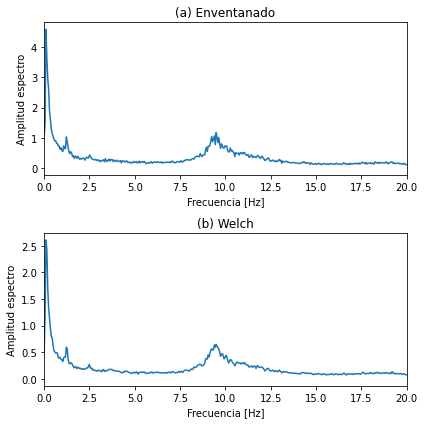

In [25]:
# Welch method
def welch(win_size, shift):
    win_size = int(win_size)
    shift = int(shift)

    ff = fftfreq(win_size, 1 / fs)[:win_size // 2]
    k = 0
    
    mean_spec = np.zeros(int(win_size / 2))
    mean_signal = np.zeros(win_size)
    n_overlap = 0
    
    win = np.hanning(win_size)

    while k + win_size < t.shape[0] - 1:
        k_top = k + shift
        xf = fft(win * eeg[k : k + win_size])[:win_size // 2]
#         fft_arr.append(xf)
        mean_spec += np.abs(xf)

        k += shift
        n_overlap += 1
        
    mxf = 2 / win_size * mean_spec / n_overlap
    
    return ff, mxf

fig, ax = plt.subplots(2, figsize=(6, 6))

win_size = N / 16
w_spec = welch(win_size, win_size / 2)

ax[0].plot(sfft0[0], sfft0[1])
ax[0].set_xlim([0, 20])
ax[0].set_title('(a) Enventanado')
ax[0].set_xlabel('Frecuencia [Hz]')
ax[0].set_ylabel('Amplitud espectro')

ax[1].plot(w_spec[0], w_spec[1])
ax[1].set_xlim([0, 20])
ax[1].set_title('(b) Welch'.format(win_size / fs, win_size / fs))
ax[1].set_xlabel('Frecuencia [Hz]')
ax[1].set_ylabel('Amplitud espectro')

print('{:.2f}'.format(t[-1] / 16))

fig.tight_layout()
fig.savefig('fig/welch_method.png')

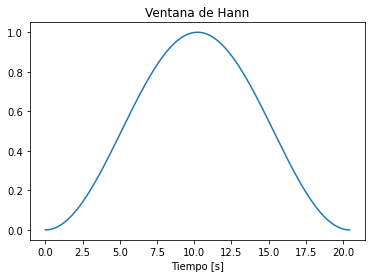

In [33]:
fig, ax = plt.subplots()
ax.plot(t[:int(win_size)], np.hanning(win_size))
ax.set_title('Ventana de Hann')
ax.set_xlabel('Tiempo [s]')
fig.savefig('fig/q1_hann.png')